# Comparing Total Hydrostatic Masses Between Analyses

This notebook measures hydrostatic masses for the samples we are using to verify our method, then compares them to the measurements from literature. These mass measurements include both the baryonic content of the intra-cluster medium, and that of the dark matter halo. This implicitly tests how close our measured temperature and density profiles are to those measured by the work we compare them to

The LoCuSS and Lovisari samples both have hydrostatic mass measurements associated with them which we will compare to, but the SDSSRM-XCS sample does not (such measurements will be presented in an upcoming paper), and the XXL-100-GC sample data is generally too shallow for such measurements.

## Import Statements

In [23]:
import pandas as pd
import numpy as np
from astropy.units import Quantity, Unit
from astropy.cosmology import LambdaCDM, WMAP9
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from copy import deepcopy

import xga
# This just sets the number of cores this analysis is allowed to use
xga.NUM_CORES = 60
from xga.samples import ClusterSample
from xga.imagetools.psf import rl_psf
from xga.sourcetools.density import inv_abel_fitted_model, ann_spectra_apec_norm
from xga.sourcetools.mass import inv_abel_dens_onion_temp
from xga.models import DoubleBetaProfile1D, SimpleVikhlininDensity1D, SimpleVikhlininTemperature1D
from xga.exceptions import ModelNotAssociatedError

## Defining useful functions

In [2]:
# This function is used for getting axis limits for the the one to one comparison plots later
def find_lims(x_dat, y_dat, buffer=0.1):
    # A buffer of some percent (default 10) is added to the max and min values to make the plot 
    #  more easily readable
    lom = 1 - buffer
    him = 1 + buffer
    
    # Check if either are all NaNs
    if np.isnan(x_dat).all():
        x_dat = y_dat.copy()
    if np.isnan(y_dat).all():
        y_dat = x_dat.copy()
    
    # Reading out the values without errors
    x_vals = x_dat[:, 0]
    y_vals = y_dat[:, 0]
    
    # Depending on whether the input data has + and - errors, or just a standard deviation, depends how
    #  we find maximum and minimum values
    if x_dat.shape[1] == 3:
        # In this case upper and lower errors are present
        lb = x_vals-x_dat[:, 1]
        # Make sure that we don't count any NaN values, and don't count any negative values
        #  The lower errors are subtracted from the measurements, and upper values added to them
        #  Then max and mins are found 
        x_lims = [np.nanmin(lb[np.where(lb>0)[0]]), np.nanmax(x_vals+x_dat[:, 2])]
    elif x_dat.shape[1] == 2:
        # The behaviour is largely the same as above, but for symmetrical errors
        lb = x_vals-x_dat[:, 1]
        x_lims = [np.nanmin(lb[np.where(lb>0)[0]]), np.nanmax(x_vals+x_dat[:, 1])]
    
    if y_dat.shape[1] == 3:
        lb = y_vals-y_dat[:, 1]
        y_lims = [np.nanmin(lb[np.where(lb>0)[0]]), np.nanmax(y_vals+y_dat[:, 2])]
    elif y_dat.shape[1] == 2:
        lb = y_vals-y_dat[:, 1]
        y_lims = [np.nanmin(lb[np.where(lb>0)[0]]), np.nanmax(y_vals+y_dat[:, 1])]
    
    # Then find the minimum and maximum values from the min and max x and y data, and multiply by the buffer
    lims = Quantity([lom*min([x_lims[0], y_lims[0]]), him*max([x_lims[1], y_lims[1]])])
    
    # Return the limits for the square like for like comparison plot
    return lims

## Reading colour configuration file

In [3]:
samp_colours = pd.read_csv("samp_plot_colours.csv")

lov_colour = samp_colours[samp_colours['samp_name'] == 'lovisari'].iloc[0]['samp_colour']
loc_colour = samp_colours[samp_colours['samp_name'] == 'locuss'].iloc[0]['samp_colour']

## Setting up cosmology

The LoCuSS and Lovisari analyses use the same concordance cosmology, but the XXL analysis of their bright cluster sample uses the WMAP9 results, and in case we wish to change anything for an individual sample later we define three separate cosmology objects to pass into our samples.

In [4]:
locuss_cosmo = LambdaCDM(70, 0.3, 0.7)
lovisari_cosmo = LambdaCDM(70, 0.3, 0.7)

## Reading in Sample Files and Declaring XGA ClusterSamples

$\color{red}{\text{NEED TO MENTION/PUBLISH THE OBSIDS THAT WE EXCLUDE FROM USE DUE TO DATA PROBLEMS LIKE FLARING}}$

This subsection involves reading in the sample files of the four test samples (described in [the sample properties notebook](sample_properties.ipynb)), then setting up separate XGA ClusterSample instances (see [the documentation](https://xga.readthedocs.io/en/latest/notebooks/tutorials/sources_samples.html) for an introduction to XGA source and sample objects.

We impose an additional cleaning step on each sample, where we make sure that (for each XMM observation initially associated with a source) at least 70% of a cluster's $R_{500}$ falls on that observation - if this requirement is not met then the observation is excluded. These requirements are set with the `clean_obs=True`, `clean_obs_reg='r500'`, and `clean_obs_threshold=0.7` arguments when a ClusterSample instance is declared.

### LoCuSS High-$L_{\rm{X}}$ - XGA centering on

The LoCuSS High-$L_{\rm{X}}$ sample was selected from ROSAT for its high luminosity clusters, and will again be a useful comparison as testing against various different analyses is beneficial in establishing the veracity of our new measurements.

In [5]:
locuss = pd.read_csv("sample_files/locuss_highlx_clusters.csv", dtype={'chandra_id': str, 'xmm_obsid': str})

In [7]:
# Reading out the relevant values into arrays just for ease of passing into the ClusterSample object
ra = locuss['ra'].values
dec = locuss['dec'].values
z = locuss['z'].values
n = locuss['name'].values
r500 = Quantity(locuss['r500'].values, 'kpc')
r2500 = Quantity(locuss['r2500'].values, 'kpc')


# Declaring the actual ClusterSample instance for the LoCuSS sample
locuss_srcs = ClusterSample(ra, dec, z, n, r500=r500, r2500=r2500, cosmology=locuss_cosmo, load_fits=True, 
                            use_peak=True, clean_obs=True, clean_obs_reg='r500', clean_obs_threshold=0.7)

Declaring BaseSource Sample:  36%|████████████████████▏                                   | 18/50 [03:05<05:50, 10.95s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/base.py:91: UserWarning: Source ZwCl0949.6+5207 does not appear to have any XMM data, and will not be included in the sample.
  warn("Source {n} does not appear to have any XMM data, and will not be included in the "
Declaring BaseSource Sample:  46%|█████████████████████████▊                              | 23/50 [03:59<05:37, 12.50s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/base.py:91: UserWarning: Source Abell1423 does not appear to have any XMM data, and will not be included in the sample.
  warn("Source {n} does not appear to have any XMM data, and will not be included in the "
Declaring BaseSource Sample:  54%|██████████████████████████████▏                         | 27/50 [04:23<03:14,  8.48s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/base.py:91: UserWarning: Source Abell1682 does 

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: Abell2219 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:963: UserWarning: A previous annular spectra profile fit for Abell2219 was not successful, or no matching spectrum has been loaded, so it cannot be read in
  warnings.warn("A previous annular spectra profile fit for {src} was not successful, or no "
Setting up Galaxy Clusters:  89%|██████████████████████████████████████████████████▊      | 41/46 [05:55<01:06, 13.28s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:109: UserWarning: There are 1 alternative matches for observation 0093031601, associated with source Abell2261
  warnings.warn("There are {0} alternative matches for observat

### Planck Selected with XMM follow-up - XGA centering on

The Lovisari et al. sample was selected from Planck-eSZ, and will again be a useful comparison as testing against various different analyses is beneficial in establishing the veracity of our new measurements.

In [6]:
lovisari = pd.read_csv("sample_files/lovisari_planck_clusters.csv")

In [8]:
# Reading out the relevant values into arrays just for ease of passing into the ClusterSample object
ra = lovisari['planck_ra'].values
dec = lovisari['planck_dec'].values
z = lovisari['z'].values
n = lovisari['name'].values
r500 = Quantity(lovisari['r500'].values, 'kpc')

# Declaring the actual ClusterSample instance for the Lovisari sample
lovisari_srcs = ClusterSample(ra, dec, z, n, r500=r500, cosmology=lovisari_cosmo, load_fits=True, use_peak=True, 
                            clean_obs=True, clean_obs_reg='r500', clean_obs_threshold=0.7)

Declaring BaseSource Sample:  50%|███████████████████████████▌                           | 60/120 [09:25<07:11,  7.18s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:794: UserWarning: G226.17-21.91 spectrum /mnt/lustre/projects/astro/general/dt237/mass_papers/XCS-Mass-Paper-I-Analysis/xga_output/0675470101/0675470101_mos2_G226.17-21.91_ra88.262_dec-21.062_ri0.0483332993719956_ro0.05437496179349506_grpTrue_mincnt5_ident72837747_6_spec.fits cannot be loaded in due to a mismatch in available ancillary files
  warnings.warn("{src} spectrum {sp} cannot be loaded in due to a mismatch in available"
Declaring BaseSource Sample:  51%|███████████████████████████▉                           | 61/120 [09:40<09:19,  9.48s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:794: UserWarning: G226.24+76.76 spectrum /mnt/lustre/projects/astro/general/dt237/mass_papers/XCS-Mass-Paper-I-Analysis/xga_output/0551280201/0551280201_mos2_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:794: UserWarning: G226.24+76.76 spectrum /mnt/lustre/projects/astro/general/dt237/mass_papers/XCS-Mass-Paper-I-Analysis/xga_output/0502690101/0502690101_mos1_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5_spec.fits cannot be loaded in due to a mismatch in available ancillary files
  warnings.warn("{src} spectrum {sp} cannot be loaded in due to a mismatch in available"
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:794: UserWarning: G226.24+76.76 spectrum /mnt/lustre/projects/astro/general/dt237/mass_papers/XCS-Mass-Paper-I-Analysis/xga_output/0502690101/0502690101_mos1_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.16191659058688912_grpTrue_mincnt5_spec.fits cannot be loaded in due to a mismatch in available ancillary files
  warnings.warn("{src} spectrum {sp} cannot be loaded in due to a mismatch in available"
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:794: UserWarni

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:794: UserWarning: G252.96-56.05 spectrum /mnt/lustre/projects/astro/general/dt237/mass_papers/XCS-Mass-Paper-I-Analysis/xga_output/0105660101/0105660101_pn_G252.96-56.05_ra49.515_dec-44.263_ri0.0_ro0.2561665126045533_grpTrue_mincnt5_spec.fits cannot be loaded in due to a mismatch in available ancillary files
  warnings.warn("{src} spectrum {sp} cannot be loaded in due to a mismatch in available"
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:794: UserWarning: G252.96-56.05 spectrum /mnt/lustre/projects/astro/general/dt237/mass_papers/XCS-Mass-Paper-I-Analysis/xga_output/0105660101/0105660101_mos2_G252.96-56.05_ra49.515_dec-44.263_ri0.0_ro0.2561665126045533_grpTrue_mincnt5_spec.fits cannot be loaded in due to a mismatch in available ancillary files
  warnings.warn("{src} spectrum {sp} cannot be loaded in due to a mismatch in available"
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:794: UserWarning:

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: G080.38-33.20 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:963: UserWarning: A previous annular spectra profile fit for G080.38-33.20 was not successful, or no matching spectrum has been loaded, so it cannot be read in
  warnings.warn("A previous annular spectra profile fit for {src} was not successful, or no "
Setting up Galaxy Clusters:  29%|████████████████▎                                       | 35/120 [05:18<09:04,  6.41s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: G093.91+34.90 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available da

Setting up Galaxy Clusters:  51%|████████████████████████████▍                           | 61/120 [08:24<09:02,  9.20s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:794: UserWarning: G226.24+76.76 spectrum /mnt/lustre/projects/astro/general/dt237/mass_papers/XCS-Mass-Paper-I-Analysis/xga_output/0551280201/0551280201_mos2_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.16191659058688912_grpTrue_mincnt5_spec.fits cannot be loaded in due to a mismatch in available ancillary files
  warnings.warn("{src} spectrum {sp} cannot be loaded in due to a mismatch in available"
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:794: UserWarning: G226.24+76.76 spectrum /mnt/lustre/projects/astro/general/dt237/mass_papers/XCS-Mass-Paper-I-Analysis/xga_output/0551280201/0551280201_pn_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.16191659058688912_grpTrue_mincnt5_spec.fits cannot be loaded in due to a mismatch in available ancillary files
  warnings.warn("{src} spectrum {sp} cannot

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:794: UserWarning: G226.24+76.76 spectrum /mnt/lustre/projects/astro/general/dt237/mass_papers/XCS-Mass-Paper-I-Analysis/xga_output/0502690101/0502690101_mos1_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5_spec.fits cannot be loaded in due to a mismatch in available ancillary files
  warnings.warn("{src} spectrum {sp} cannot be loaded in due to a mismatch in available"
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:794: UserWarning: G226.24+76.76 spectrum /mnt/lustre/projects/astro/general/dt237/mass_papers/XCS-Mass-Paper-I-Analysis/xga_output/0502690101/0502690101_mos1_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.16191659058688912_grpTrue_mincnt5_spec.fits cannot be loaded in due to a mismatch in available ancillary files
  warnings.warn("{src} spectrum {sp} cannot be loaded in due to a mismatch in available"
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:794: UserWarni

Setting up Galaxy Clusters:  58%|████████████████████████████████▋                       | 70/120 [09:42<05:41,  6.82s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:963: UserWarning: A previous annular spectra profile fit for G244.34-32.13 was not successful, or no matching spectrum has been loaded, so it cannot be read in
  warnings.warn("A previous annular spectra profile fit for {src} was not successful, or no "
Setting up Galaxy Clusters:  62%|██████████████████████████████████▌                     | 74/120 [09:58<03:38,  4.75s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: G250.90-36.25 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  62%|███████████████████████████████████                     | 75/120 [10:06<04:

Setting up Galaxy Clusters:  70%|███████████████████████████████████████▏                | 84/120 [11:17<04:51,  8.09s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:963: UserWarning: A previous annular spectra profile fit for G266.03-21.25 was not successful, or no matching spectrum has been loaded, so it cannot be read in
  warnings.warn("A previous annular spectra profile fit for {src} was not successful, or no "
Setting up Galaxy Clusters:  73%|█████████████████████████████████████████               | 88/120 [11:46<03:43,  6.98s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/extended.py:221: UserWarning: A point source has been detected in 0105262501 and is very close to the user supplied coordinates of G272.10-40.15. It will not be excluded from analysis due to the possibility of a mis-identified cool core
  warnings.warn("A point source has been detected in {o} and is very close to the user supplied "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/

## Running PSF Correction

In [10]:
rl_psf(locuss_srcs)
rl_psf(lovisari_srcs)

## Reading in literature data

###   $\color{red}{\text{Hydrostatic masses from literature}}$

In [11]:
lov_lit_ms = [lovisari[lovisari['name'] == n].iloc[0][['m500', 'm500-', 'm500+']].values*1e+13
               for n in lovisari_srcs.names]
lov_lit_ms = Quantity(lov_lit_ms, 'Msun')

loc_lit_ms = [locuss[locuss['name'] == n].iloc[0][['x_m500', 'x_m500_err']].values
               for n in locuss_srcs.names]
loc_lit_ms = Quantity(loc_lit_ms, 'Msun')

### Conversion Temperatures

In [15]:
loc_conv_txs = []
lov_conv_txs = []

for src in locuss_srcs:
    loc_conv_txs.append(locuss[locuss['name'] == src.name].iloc[0]['x_Tx500ce'])

for src in lovisari_srcs:
    lov_conv_txs.append(lovisari[lovisari['name'] == src.name].iloc[0]['Tx'])

loc_conv_txs = Quantity(loc_conv_txs, 'keV')
lov_conv_txs = Quantity(lov_conv_txs, 'keV')

## Hydrostatic Mass Comparison to Literature - Density from $S_B$ Profiles

### Double Beta and Simplified Vikhlinin Density/Temperature Profiles - out to 1.05$R_{500}$

In [16]:
demo_sb_mod = DoubleBetaProfile1D()
demo_sb_mod.info()
demo_sb_mod.par_priors

╒═══════════════════════╤════════════════════════════════════════════════════════════════════════════╕
│ Double Beta Profile   │                                                                            │
╞═══════════════════════╪════════════════════════════════════════════════════════════════════════════╡
│ DESCRIBES             │ Surface Brightness                                                         │
├───────────────────────┼────────────────────────────────────────────────────────────────────────────┤
│ UNIT                  │ ct / (arcmin2 s)                                                           │
├───────────────────────┼────────────────────────────────────────────────────────────────────────────┤
│ PARAMETERS            │ beta_one, r_core_one, norm_one, beta_two, r_core_two, norm_two             │
├───────────────────────┼────────────────────────────────────────────────────────────────────────────┤
│ PARAMETER UNITS       │ , kpc, ct / (arcmin2 s), , kpc, ct / (arcmin2 s

[{'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [1.e+00, 2.e+03] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.] ct / (arcmin2 s)>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [1.e+00, 2.e+03] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.] ct / (arcmin2 s)>, 'type': 'uniform'}]

In [18]:
demo_d_mod = SimpleVikhlininDensity1D(y_unit=Unit("1 / cm^3"))
demo_d_mod.info()
demo_d_mod.par_priors

╒════════════════════════════════╤═══════════════════════════════════════════════════════════════════════╕
│ Simplified Vikhlinin Profile   │                                                                       │
╞════════════════════════════════╪═══════════════════════════════════════════════════════════════════════╡
│ DESCRIBES                      │ Gas Density                                                           │
├────────────────────────────────┼───────────────────────────────────────────────────────────────────────┤
│ UNIT                           │ 1 / cm3                                                               │
├────────────────────────────────┼───────────────────────────────────────────────────────────────────────┤
│ PARAMETERS                     │ beta, r_core, alpha, r_s, epsilon, norm                               │
├────────────────────────────────┼───────────────────────────────────────────────────────────────────────┤
│ PARAMETER UNITS                │ , 

[{'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [   0., 2000.] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [   0., 2000.] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 5.]>, 'type': 'uniform'},
 {'prior': <Quantity [ 0., 10.] 1 / cm3>, 'type': 'uniform'}]

In [24]:
demo_t_mod = SimpleVikhlininTemperature1D()
demo_t_mod.info()
demo_t_mod.par_priors

╒════════════════════════════════╤═════════════════════════════════════════════════════════════════════╕
│ Simplified Vikhlinin Profile   │                                                                     │
╞════════════════════════════════╪═════════════════════════════════════════════════════════════════════╡
│ DESCRIBES                      │ Gas Temperature                                                     │
├────────────────────────────────┼─────────────────────────────────────────────────────────────────────┤
│ UNIT                           │ keV                                                                 │
├────────────────────────────────┼─────────────────────────────────────────────────────────────────────┤
│ PARAMETERS                     │ r_cool, a_cool, t_min, t_zero, r_tran, c_power                      │
├────────────────────────────────┼─────────────────────────────────────────────────────────────────────┤
│ PARAMETER UNITS                │ kpc, , keV, keV, kpc

[{'prior': <Quantity [   0., 2000.] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [-10.,  10.]>, 'type': 'uniform'},
 {'prior': <Quantity [ 0., 15.] keV>, 'type': 'uniform'},
 {'prior': <Quantity [ 0., 15.] keV>, 'type': 'uniform'},
 {'prior': <Quantity [   0., 2000.] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [-10.,  10.]>, 'type': 'uniform'}]

In [26]:
loc_sb_dblbeta_simpvikh_105_mp = inv_abel_dens_onion_temp(locuss_srcs, locuss_srcs.r500*1.05, 'double_beta', 
                                                          'simple_vikhlinin_dens', 'simple_vikhlinin_temp', 'r500', 
                                                          temp_min_snr=30)

Running XSPEC Fits: 100%|█████████████████████████████████████████████████████████████████| 46/46 [09:05<00:00, 11.85s/it]
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/temperature.py:152: UserWarning: The requested annuli for RXCJ1212.3-1816 cannot be created, the data quality is too low. As such a set of four annuli will be returned
  warn("The requested annuli for {s} cannot be created, the data quality is too low. As such a set "
Generating products of type(s) spectrum: 100%|████████████████████████████████████████| 210/210 [1:37:02<00:00, 27.72s/it]
Generating products of type(s) annular spectrum set components: 100%|███████████████| 2591/2591 [3:02:19<00:00,  4.22s/it]
Running XSPEC Fits: 100%|███████████████████████████████████████████████████████████████| 540/540 [19:57<00:00,  2.22s/it]
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/xspec/run.py:326: UserWarning: Abell0963 annular spectra profile fit was not successful
  warnings.warn("{src} annular spectra profile fi

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1229.14529149 1100.49414714 1434.2044592  1077.20861762 1205.54654386
 1195.1302909 ]


Fitting data, inverse Abel transforming, and measuring densities:   5%|▉                   | 2/41 [00:51<17:02, 26.22s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [774.42196213 665.44705779 746.11352968 681.37584153 685.10009775
 828.1675351 ]


Fitting data, inverse Abel transforming, and measuring densities:   7%|█▍                  | 3/41 [01:17<16:22, 25.85s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1699.98765624  646.40236017 1918.27820976 1387.04695041 1572.68120703
 1809.8705095 ]


Fitting data, inverse Abel transforming, and measuring densities:  10%|█▉                  | 4/41 [01:41<15:34, 25.26s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1500.92908433 1472.6148793  1865.17866583 1634.31679224 1638.29708579
 1834.95739728]


Fitting data, inverse Abel transforming, and measuring densities:  12%|██▍                 | 5/41 [02:05<14:50, 24.75s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [400.29722854 848.42829828 226.49995004 220.07103945 501.52264934
 535.918696  ]


Fitting data, inverse Abel transforming, and measuring densities:  15%|██▉                 | 6/41 [02:30<14:24, 24.69s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1086.78668289  933.62483145 1393.53970219  988.70529035 1498.06920996
 1428.21232594]


Fitting data, inverse Abel transforming, and measuring densities:  20%|███▉                | 8/41 [03:22<13:55, 25.31s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 275.67461288  240.13298236 1816.91650966 1698.29479213 1807.75307692
 1805.81781215]


Fitting data, inverse Abel transforming, and measuring densities:  32%|██████             | 13/41 [05:35<12:14, 26.23s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [878.11184366 163.799635   855.31244206 684.88924786 832.42565843
 851.13661748]


Fitting data, inverse Abel transforming, and measuring densities:  34%|██████▍            | 14/41 [06:02<11:52, 26.37s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1065.78406437 1057.58119807  970.29089328  835.70485822  915.86931289
 1062.79013263]


Fitting data, inverse Abel transforming, and measuring densities:  37%|██████▉            | 15/41 [06:27<11:16, 26.02s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [159.0592     448.76189408 248.16303007 203.0743091  294.47503272
 357.13292933]


Fitting data, inverse Abel transforming, and measuring densities:  51%|█████████▋         | 21/41 [09:04<08:30, 25.53s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [183.85273046 569.07435164 304.87873843 804.91964279 784.84250988
 616.01056552]


Fitting data, inverse Abel transforming, and measuring densities:  56%|██████████▋        | 23/41 [09:58<07:50, 26.12s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [145.54357295 410.57231546 100.79500788 138.95675495 176.88377555
 251.31035006]


Fitting data, inverse Abel transforming, and measuring densities:  59%|███████████        | 24/41 [10:23<07:20, 25.91s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [2004.56599566 1313.47958286 2335.84275693 1999.36416183 2195.14693363
 2336.56860684]


Fitting data, inverse Abel transforming, and measuring densities:  71%|█████████████▍     | 29/41 [12:40<05:18, 26.50s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 625.33450923 1370.61242589 1852.37515868 2199.49654914 2257.30949464
 2066.78582232]


Fitting data, inverse Abel transforming, and measuring densities:  73%|█████████████▉     | 30/41 [13:04<04:45, 25.93s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1082.58546147  704.00347939 1376.5534789  1308.18992686 1374.11344113
 1451.78868018]


Fitting data, inverse Abel transforming, and measuring densities:  83%|███████████████▊   | 34/41 [14:56<03:11, 27.41s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [718.1483636  741.23957528 798.07725339 650.80938357 772.70054067
 808.41530569]


Fitting data, inverse Abel transforming, and measuring densities:  93%|█████████████████▌ | 38/41 [16:46<01:21, 27.21s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1334.64431143  693.51305064 1257.99124804 1009.1704986  1137.15980445
 1260.75062611]


Fitting data, inverse Abel transforming, and measuring densities:  95%|██████████████████ | 39/41 [17:13<00:53, 26.95s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [407.38021617 417.38695752 450.25177498 313.64427925 408.24227703
 512.2851286 ]


Fitting data, inverse Abel transforming, and measuring densities: 100%|███████████████████| 41/41 [18:03<00:00, 26.42s/it]


The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 979.15733576  244.53660969 1976.01397204 1753.05637497 1414.9678549
 1915.96872798]


Generating Abell2697 hydrostatic mass profile:   0%|                                               | 0/46 [00:00<?, ?it/s]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [567.1133016  822.23760149 562.22116335 464.28934121 911.91309171
 406.83524979]
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 112.62816036  164.03784508 1300.17448828  110.86765916  110.27143709
  565.53697013]


Generating Abell0068 hydrostatic mass profile:   2%|▊                                      | 1/46 [00:49<37:25, 49.90s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [301.88963025 477.75982239 386.94530657 438.98725263 314.31978327
 322.37969616]


Generating Abell2813 hydrostatic mass profile:   4%|█▋                                     | 2/46 [01:39<36:35, 49.89s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [628.1654569  809.68872461 641.87711542 777.9772017  904.5102499
 464.18701743]
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [198.33568831 339.2362879  582.0418806  157.49398188 130.83359708
 516.36129738]


Generating Abell0115S hydrostatic mass profile:   7%|██▍                                   | 3/46 [02:29<35:37, 49.72s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1269.07210821 1720.52584687 2440.86683826 1509.24977213  583.62211925
 1503.77843876]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 216.61464814  218.3541352  1493.88546074  261.84745373  230.81344076
  283.71737725]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating Abell141 hydrostatic mass profile:   9%|███▍                                    | 4/46 [03:18<34:32, 49.36s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [770.5768317  640.67409535 637.90986532 700.12870846 527.73651003
 596.81632278]
The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [418.33260742 417.24907459 427.91133001 599.56501932 370.87311282
 520.87887552]


Generating ZwCl0104.4+0048 hydrostatic mass profile:  11%|███▌                             | 5/46 [04:06<33:27, 48.97s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1281.4723147  1446.52166738 1393.8731075  1473.94681327 2154.43383618
 1620.66060174]


Generating Abell0209 hydrostatic mass profile:  13%|█████                                  | 6/46 [04:51<31:46, 47.67s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 123.27812719  121.77752594 1085.53340786  197.99987777  172.18183634
  132.50103824]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [615.68999254 887.05925208 668.77851025 516.38991462 497.61777579
 510.15878694]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 810.3126211  1006.11956817 1192.71545334  490.18950031  826.20743311
 1047.10185018]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating Abell0267 hydrostatic mass profile:  15%|█████▉                                 | 7/46 [05:43<31:54, 49.09s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [333.45575025 868.87699614 495.02054145 535.34718636 392.83124713
 350.12300367]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 104.97944888  103.51498585 1058.73297278  107.20836752  118.98996847
  100.34559668]


Generating Abell0291 hydrostatic mass profile:  17%|██████▊                                | 8/46 [06:32<31:04, 49.07s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [579.74401899 666.48220885 249.66064897 505.74993782 360.15814483
 338.90027826]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 88.86562287  92.77132765 744.68959442  86.29210982  86.44225057
  89.87285067]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating Abell0383 hydrostatic mass profile:  20%|███████▋                               | 9/46 [07:24<30:47, 49.94s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1458.59207319 1640.95112913 1356.78816024 1228.57497744 2016.46332043
 1392.1202297 ]


Generating Abell0521 hydrostatic mass profile:  22%|████████▎                             | 10/46 [08:14<30:04, 50.12s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1105.33182931 1080.51437031  757.67929506 1194.19720228  635.04159047
  490.31416787]


Generating Abell0586 hydrostatic mass profile:  24%|█████████                             | 11/46 [09:04<29:09, 49.98s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [504.18243852 708.28179266 483.64210262 573.74564421 487.30422511
 367.53719489]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating Abell0611 hydrostatic mass profile:  26%|█████████▉                            | 12/46 [09:54<28:22, 50.07s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 367.20904717 1184.93339418  388.78242005  338.97173692  347.97180286
  362.06834492]
The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [319.60458918 408.91457512 726.79793402 262.48369654 182.83739475
 459.44343009]


Generating ZwCl0857.9+2107 hydrostatic mass profile:  30%|█████████▋                      | 14/46 [10:43<26:27, 49.60s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 412.72060485 1441.56189812  760.10310555  726.22904953  401.74894506
  396.99977257]


Generating Abell0750 hydrostatic mass profile:  33%|████████████▍                         | 15/46 [11:30<19:22, 37.51s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [102.69472376 114.84551217 695.19350072 117.97012132 121.07318106
 131.62658457]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 983.67558276 1224.2819758  1201.77185115 1175.41165145  785.29672287
  987.38229512]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating Abell0781 hydrostatic mass profile:  37%|██████████████                        | 17/46 [12:19<19:27, 40.25s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [970.927525   868.61705408 298.49909469 715.02991959 295.28052691
 388.15400206]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1061.40731167  855.89230064  889.90343609  566.7368844   441.57927329
  503.33502912]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [104.72419312 148.78557002 888.87485087 104.69937598 116.53076619
 178.35511401]


Generating Abell0901 hydrostatic mass profile:  39%|██████████████▊                       | 18/46 [13:06<15:37, 33.49s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1246.16942689 1342.27257972  801.59988675  788.08846624 1917.07821065
 1155.57346944]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 86.16924606  86.74695989 707.99746917 102.28462049 105.10011796
  84.84045493]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating Abell0907 hydrostatic mass profile:  41%|███████████████▋                      | 19/46 [13:57<16:50, 37.43s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [505.38247116 550.15290495 251.56941362 403.70347144 282.79677232
 265.69936334]


Generating ZwCl1021.0+0426 hydrostatic mass profile:  46%|██████████████▌                 | 21/46 [14:51<17:15, 41.44s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1325.51631177 1536.79171315 1477.07472372 1549.29736285 1127.72422333
  808.58219796]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 86.52047365  88.1376582  886.46036704  79.35946793 145.05574682
  60.00437741]


Generating RXCJ1212.3-1816 hydrostatic mass profile:  50%|████████████████                | 23/46 [15:40<13:13, 34.50s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [660.49129924 873.57374486 677.99363357 717.49594489 701.18405534
 744.82002707]


Generating ZwCl1231.4+1007 hydrostatic mass profile:  52%|████████████████▋               | 24/46 [16:24<10:56, 29.86s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 947.34091755  693.42436913  676.30653685 1015.3318928   403.09311843
  744.11688657]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 747.38400436  797.76705426  660.01174282 1007.65011631  921.7193512
  517.01994332]
The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 327.44709736  783.18475777 1171.68756968  247.17638004  185.22412647
  911.09542473]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating Abell1689 hydrostatic mass profile:  54%|████████████████████▋                 | 25/46 [17:14<11:53, 33.99s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 910.32549114 1048.76846368 1223.43819075 1323.65251025  769.68935715
  999.36476059]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 86.09435953  81.68835781 580.18339307  90.08733145  89.59344442
  78.29428329]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating Abell1758N hydrostatic mass profile:  57%|████████████████████▉                | 26/46 [18:09<12:57, 38.87s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1012.8473945  1020.9216412  1063.39693695 1089.74823672  664.69162616
  956.67063261]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1868.98194458 2035.14397942 1958.30849841 1971.31222757 1069.02958135
 2034.55827176]


Generating Abell1763 hydrostatic mass profile:  59%|██████████████████████▎               | 27/46 [18:59<13:11, 41.64s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [317.13256638 659.65696242 504.44096458 414.41158961 318.8996841
 397.2666281 ]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [186.52248614 175.94511086 718.463923   341.70381355 395.08742751
 203.191875  ]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating Abell1835 hydrostatic mass profile:  61%|███████████████████████▏              | 28/46 [19:50<13:13, 44.06s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1584.83867    1278.02598612 1523.25163121 1677.25750785  684.7397223
 1238.53455913]


Generating Abell1914 hydrostatic mass profile:  63%|███████████████████████▉              | 29/46 [20:44<13:17, 46.91s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [455.83955571 542.20018831 520.49005345 560.24129114 489.92006779
 389.74517263]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 93.75143991  95.62412169 438.49170815  88.3046599   84.51631137
  96.82641406]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating ZwCl1454.8+2233 hydrostatic mass profile:  65%|████████████████████▊           | 30/46 [21:38<13:01, 48.84s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1006.61269726 1190.4734581   464.8373566   784.57655389  362.28289502
  351.73757168]


Generating Abell2009 hydrostatic mass profile:  67%|█████████████████████████▌            | 31/46 [22:27<12:13, 48.89s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [  99.21679447   93.21008315 1212.91865996  104.73780153  116.82433156
   90.71059295]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [455.19128471 627.03392545 509.6213491  337.12652852 218.29885306
 233.79496648]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [142.64775801 303.73948085 606.05477417 111.11460508 146.10578614
 394.55865546]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating ZwCl1459.4+4240 hydrostatic mass profile:  70%|██████████████████████▎         | 32/46 [23:23<11:52, 50.91s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [740.19458382 896.02432952 569.57267585 788.78886665 577.87900025
 539.42568209]


Generating RXCJ1504.1-0248 hydrostatic mass profile:  72%|██████████████████████▉         | 33/46 [24:12<10:55, 50.39s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [392.47279162 547.31288255 316.35484994 327.55590171 473.78777153
 382.44606372]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [518.52109798 563.76905632 295.10153529 416.6435194  224.27940709
 228.15489261]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [  79.76652336   79.85067413 1211.88922726   84.96892575   98.49498485
   60.84709344]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating Abell2111 hydrostatic mass profile:  74%|████████████████████████████          | 34/46 [25:07<10:21, 51.77s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [362.87136748 449.5230545  416.16337586 364.72247482 335.17935023
 318.37057533]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [111.27708263 124.81874274 433.88006505 105.80514683  93.78599599
 134.33478376]


Generating Abell2204 hydrostatic mass profile:  76%|████████████████████████████▉         | 35/46 [25:58<09:27, 51.56s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [372.96364414 450.53096189 169.28089899 386.57201583 163.09390769
 160.35278459]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating RXJ1720.1+2638 hydrostatic mass profile:  80%|██████████████████████████▌      | 37/46 [26:58<08:05, 53.99s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [576.96940617 646.76821766 201.20669915 561.28210047 249.5460558
 296.70771259]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 82.94850713  81.27909556 674.91153433  79.6878515   76.25331038
  65.94835005]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating Abell2261 hydrostatic mass profile:  83%|███████████████████████████████▍      | 38/46 [27:54<05:35, 41.92s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1010: UserWarning: Optimal parameters not found: The maximum number of function evaluations is exceeded., curve_fit has failed.
  warn("{}, curve_fit has failed.".format(str(r_err)))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:810: UserWarning: Maximum likelihood estimator has produced at least one start parameter that is outside the allowed values defined by the prior, reverting to default start parameters for this model.
  warn("Maximum likelihood estimator h

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [694.59103417 994.75949087 720.33175607 662.93095763 589.46425068
 627.91542199]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 84.79518459  88.1207048  548.33066065  79.46700639  84.38160565
  90.23217604]


Generating RXCJ2102.1-2431 hydrostatic mass profile:  85%|███████████████████████████▏    | 39/46 [28:45<05:10, 44.39s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1283.57600998 1557.72591091 1689.15894139 1351.96258824 2335.90857698
 1677.73696983]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 77.12539256  81.64165903 678.52453769  86.42911592  87.96925991
  83.08453341]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating RXJ2129.6+0005 hydrostatic mass profile:  87%|████████████████████████████▋    | 40/46 [29:36<04:36, 46.00s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [614.43265943 991.29383973 980.51126552 692.99860457 467.69771938
 501.35846518]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 78.36319491  80.89359703 433.89616571  79.01066175  83.79408514
  87.6692705 ]


Generating Abell2390 hydrostatic mass profile:  89%|█████████████████████████████████▊    | 41/46 [30:27<03:57, 47.49s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 83.99651791  87.90874527 792.17286459  79.6377599   81.27776413
  87.48022075]


Generating Abell2537 hydrostatic mass profile:  91%|██████████████████████████████████▋   | 42/46 [31:23<03:18, 49.67s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [429.55400704 571.64791155 420.54666679 431.68262927 448.98504708
 358.35620876]


Generating Abell2552 hydrostatic mass profile:  93%|███████████████████████████████████▌  | 43/46 [32:11<02:27, 49.33s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 246.00974857  703.66361839 1613.07400609  176.15362549  130.38861514
 1069.14900191]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [487.88368142 839.56614177 410.92754599 547.18217114 771.28835684
 466.51002653]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [133.72127814 213.09248203 469.59284984 109.19569227 138.8340162
 250.37321635]


Generating Abell2631 hydrostatic mass profile:  96%|████████████████████████████████████▎ | 44/46 [33:01<01:39, 49.54s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [309.08403475 544.97267215 430.83689959 465.93205172 399.78986831
 385.17455942]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 951.60763441 1641.61677995 1021.73666611  882.53485986 1226.19794497
 1516.60353953]


Generating Abell2645 hydrostatic mass profile:  98%|█████████████████████████████████████▏| 45/46 [33:52<00:49, 49.94s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [538.7204532  680.54843825 501.85528042 662.56080272 443.78359452
 503.80976796]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [106.73791571 114.48968649 609.88127849 107.36471136 115.74461835
 152.95543262]


Complete: 100%|███████████████████████████████████████████████████████████████████████████| 46/46 [34:40<00:00, 45.24s/it]


In [ ]:
lov_sb_dblbeta_simpvikh_105_mp = inv_abel_dens_onion_temp(lovisari_srcs, lovisari_srcs.r500*1.05, 'double_beta', 
                                                          'simple_vikhlinin_dens', 'simple_vikhlinin_temp', 'r500', 
                                                          temp_min_snr=30)

Running XSPEC Fits:   0%|                                                                         | 0/119 [00:00<?, ?it/s]

In [28]:
len(loc_sb_dblbeta_simpvikh_105_mp)

46

In [33]:
loc_sb_dblbeta_simpvikh_105_m500 = []
with tqdm(desc='Measuring Masses for LoCuSS Clusters', total=len(loc_sb_dblbeta_simpvikh_105_mp)) as onwards:
    for mp in loc_sb_dblbeta_simpvikh_105_mp:
        if mp is not None:
            rel_src = locuss_srcs[mp.src_name]
            m = mp.mass(rel_src.r500)[0]
        else:
            m = Quantity([np.NaN, np.NaN, np.NaN], 'Msun')
        loc_sb_dblbeta_simpvikh_105_m500.append(m)
        
        onwards.update(1)

loc_sb_dblbeta_simpvikh_105_m500 = Quantity(loc_sb_dblbeta_simpvikh_105_m500)

Measuring Masses for LoCuSS Clusters: 100%|█████████████████████████████████████████████| 46/46 [00:00<00:00, 1346.48it/s]


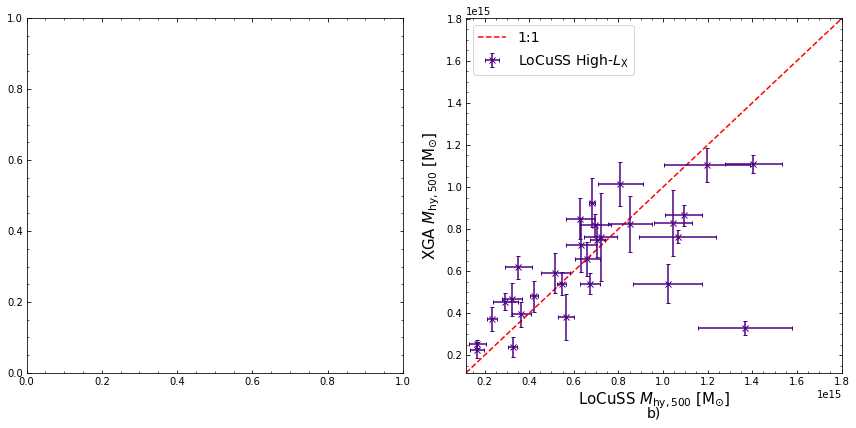

In [43]:
# Setting the y-position and font size of the a and b labels that are added below the subplots
sublabel_ypos = -0.115
sublabel_fsize = 14

# Set up the matplotlib figure with 2 columns, meaning three subplots
fig, ax_arr = plt.subplots(ncols=2, figsize=(12, 6))

# Iterating through the array of axes objects, setting up the ticks
for ax in ax_arr:
    ax.minorticks_on()
    ax.tick_params(which='both', top=True, right=True, direction='in')

# Reading out the first axis in the array of axes
ax = ax_arr[0]
plt.sca(ax)

# # Fetching appropriate limits for comparing the two sets of gas-mass measurements
# lov_lims = find_lims(lov_lit_gms, lov_dblbeta_svikh_13_gm).value

# # Plotting a 1:1 line to help with comparisons
# plt.plot(lov_lims, lov_lims, color='red', linestyle="dashed", label="1:1")
# # Plotting the two datasets with uncertainties
# plt.errorbar(lov_lit_gms[:, 0].value, lov_dblbeta_svikh_13_gm[:, 0].value, 
#              xerr=lov_lit_gms[:, 1:].T.value, 
#              yerr=lov_dblbeta_svikh_13_gm[:, 1:].T.value, fmt='x', 
#              color=lov_colour, capsize=2, label="Lovisari et al.")

# # Labelling axes, setting labels etc.
# ax.set_xlabel(r"Lovisari Gas Mass [M$_{\odot}$]", fontsize=15)
# ax.set_xlim(lov_lims)
# ax.set_ylabel("XGA Gas Mass [M$_{\odot}$]", fontsize=15)
# ax.set_ylim(lov_lims)
# ax.text(0.5, sublabel_ypos, s='a)', horizontalalignment='center', verticalalignment='center', 
#         transform=ax.transAxes, fontsize=sublabel_fsize)
# ax.legend(loc='best', fontsize=14)

# Reading out the second axis in the array of axes
ax = ax_arr[1]
plt.sca(ax)

# Fetching appropriate limits for comparing the two sets of mass measurements
loc_lims = find_lims(loc_lit_ms, loc_sb_dblbeta_simpvikh_105_m500).value

# Plotting a 1:1 line to help with comparisons
plt.plot(loc_lims, loc_lims, color='red', linestyle="dashed", label="1:1")
# Plotting the two datasets with uncertainties
plt.errorbar(loc_lit_ms[:, 0].value, loc_sb_dblbeta_simpvikh_105_m500[:, 0].value, 
             xerr=loc_lit_ms[:, 1].value, 
             yerr=loc_sb_dblbeta_simpvikh_105_m500[:, 1].T.value, fmt='x', 
             color=loc_colour, capsize=2, label=r"LoCuSS High-$L_{\rm{X}}$")

# Labelling axes, setting labels etc.
ax.set_xlabel(r"LoCuSS $M_{\rm{hy, 500}}$ [M$_{\odot}$]", fontsize=15)
ax.set_xlim(loc_lims)
ax.set_ylabel(r"XGA $M_{\rm{hy,500}}$ [M$_{\odot}$]", fontsize=15)
ax.set_ylim(loc_lims)
ax.text(0.5, sublabel_ypos, s='b)', horizontalalignment='center', verticalalignment='center', 
        transform=ax.transAxes, fontsize=sublabel_fsize)
ax.legend(loc='best', fontsize=14)

# Saving and plotting the resulting figure
plt.tight_layout()
plt.savefig("non_paper_figures/lov_loc_sb_dblbeta_svikh_1.05r500_hym500_comp.pdf")
plt.show()